In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from main_model import MainModel

plt.ion()

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Using CUDA


In [ ]:
!unzip drive/MyDrive/3features.zip

Streaming output truncated to the last 5000 lines.
  inflating: 3features/test/other/20180612_FIRE_rm-w-mobo-c_1528842726_+01740_sbb_horizon_6_flipped.jpg  
  inflating: 3features/test/other/20190924_FIRE_bl-s-mobo-c_1569363173_+01080_sbb_horizon_3.jpg  
  inflating: 3features/test/other/20190924_FIRE_wc-e-mobo-c_1569362781_+00421_sbb_horizon_2_rotated.jpg  
  inflating: 3features/test/other/20190728_Dehesa_lp-n-mobo_1564363801_+01980_sbb_horizon_1.jpg  
  inflating: 3features/test/other/20191006_FIRE_pi-s-mobo-c_1570388167_+02398_sbb_horizon_2_rotated.jpg  
  inflating: 3features/test/other/20170627_FIRE_lp-n-iqeye_1498581912_+00480_sbb_horizon_2_rotated.jpg  
  inflating: 3features/test/other/20190728_Dehesa_lp-n-mobo_1564363801_+01980_sbb_horizon_6.jpg  
  inflating: 3features/test/other/20170627_FIRE_lp-n-iqeye_1498581912_+00480_sbb_horizon_3_flipped.jpg  
  inflating: 3features/test/other/20191006_FIRE_pi-s-mobo-c_1570388167_+02398_sbb_horizon_3_flipped.jpg  
  inflating: 3feature

In [ ]:
!unzip drive/MyDrive/3features.zip > /dev/null

replace 3features/train/other/20190715_MLOSouth2_lo-s-mobo-c_1563224963_+02160_sbb_ground_2_1_rotated.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
data_dir = '3features/'
TRAIN = 'train'
VAL = 'val'
TEST = 'test'

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transforms = {
    TRAIN: transforms.Compose([
        # Data augmentation is a good practice for the train set
        # Here, we randomly crop the image to 224x224 and
        # randomly flip it horizontally.
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    VAL: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
    TEST: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x),
        transform=data_transforms[x]
    )
    for x in [TRAIN, VAL, TEST]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=8,
        shuffle=True, num_workers=4
    )
    for x in [TRAIN, VAL, TEST]
}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL, TEST]}

for x in [TRAIN, VAL, TEST]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))

print("Classes: ")
class_names = image_datasets[TRAIN].classes
print(image_datasets[TRAIN].classes)

Loaded 14318 images under train
Loaded 3671 images under val
Loaded 1843 images under test
Classes: 
['cloud', 'other', 'smoke']


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
main_model = MainModel(
                     model_type_list=['RawToTile_ResNet'],
                     pretrain_epochs=None,
                     intermediate_supervision=True,
                     error_as_eval_loss=False,
                     use_image_preds=False,

                     tile_loss_type='bce',
                     bce_pos_weight=36,
                     focal_alpha=0.25,
                     focal_gamma=2,
                     image_loss_only=False,
                     image_pos_weight=1,
                     confidence_threshold=0,

                     series_length = 2,
                     num_tiles = 1,

                     num_tiles_height=1,
                     num_tiles_width=1,

                     is_background_removal=False


                  )

Initializing MainModel...
- RawToTile_ResNet_small


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 204MB/s]


-- Tile Loss: BCE Loss
Initializing MainModel Complete.


In [ ]:
def train_model(vgg, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0

    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0

    train_batches = len(dataloaders[TRAIN])
    val_batches = len(dataloaders[VAL])

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)

        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0

        vgg.train(True)

        for i, data in enumerate(dataloaders[TRAIN]):
            if i % 100 == 0:
                print("\rTraining batch {}/{}".format(i, train_batches / 2), end='', flush=True)

            # Use half training dataset
            if i >= train_batches / 2:
                break

            inputs, labels = data

            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)

            optimizer.zero_grad()

            outputs = vgg(inputs)

            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            loss_train += loss.data.item()
            acc_train += torch.sum(preds == labels.data)

            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()

        print()
        # * 2 as we only used half of the dataset
        avg_loss = loss_train * 2 / dataset_sizes[TRAIN]
        avg_acc = acc_train * 2 / dataset_sizes[TRAIN]

        vgg.train(False)
        vgg.eval()

        for i, data in enumerate(dataloaders[VAL]):
            if i % 100 == 0:
                print("\rValidation batch {}/{}".format(i, val_batches), end='', flush=True)

            inputs, labels = data

            if use_gpu:
                inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
            else:
                inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)

            optimizer.zero_grad()

            outputs = vgg(inputs)

            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

            loss_val += loss.data.item()
            acc_val += torch.sum(preds == labels.data)

            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()

        avg_loss_val = loss_val / dataset_sizes[VAL]
        avg_acc_val = acc_val / dataset_sizes[VAL]

        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (val): {:.4f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()

        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(vgg.state_dict())

    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))

    vgg.load_state_dict(best_model_wts)
    return vgg

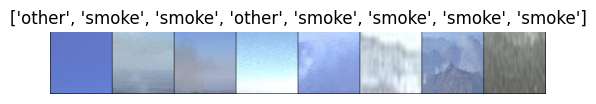

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(dataloaders[TRAIN]))
show_databatch(inputs, classes)

In [ ]:
def visualize_model(vgg, num_images=6):
    was_training = vgg.training

    # Set model for evaluation
    vgg.train(False)
    vgg.eval()

    images_so_far = 0

    for i, data in enumerate(dataloaders[TEST]):
        inputs, labels = data
        size = inputs.size()[0]

        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)

        outputs = vgg(inputs)

        _, preds = torch.max(outputs.data, 1)
        predicted_labels = [preds[j] for j in range(inputs.size()[0])]


        print("Ground truth:")
        show_databatch(inputs.data.cpu(), labels.data.cpu())
        print("Prediction:")
        show_databatch(inputs.data.cpu(), predicted_labels)

        del inputs, labels, outputs, preds, predicted_labels
        torch.cuda.empty_cache()

        images_so_far += size
        if images_so_far >= num_images:
            break

    vgg.train(mode=was_training) # Revert model back to original training state

In [ ]:
def eval_model(vgg, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0

    test_batches = len(dataloaders[TEST])

    print("Evaluating model")
    print('-' * 10)

    for i, data in enumerate(dataloaders[TEST]):
        if i % 100 == 0:
            print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

        vgg.train(False)
        vgg.eval()
        inputs, labels = data

        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)

        outputs = vgg(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        loss_test += loss.data.item()
        acc_test += torch.sum(preds == labels.data)

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()

    avg_loss = loss_test / dataset_sizes[TEST]
    avg_acc = acc_test / dataset_sizes[TEST]

    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)

In [ ]:

print(main_model)

MainModel(
  (model_list): ModuleList(
    (0): RawToTile_ResNet(
      (conv): ResNet(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=

In [ ]:
resume_training = True

if resume_training:
    print("Loading pretrained model..")
    main_model.load_state_dict(torch.load('/content/3features/UCSDmodel(3features).pt'))
    print("Loaded!")

Loading pretrained model..
Loaded!


In [ ]:
if use_gpu:
    main_model.cuda() #.cuda() will move everything to the GPU side

criterion = nn.CrossEntropyLoss()

# optimizer_ft = optim.SGD(main_model.parameters(), lr=0.001, momentum=0.9)
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
print("Test before training")
eval_model(main_model, criterion)

Test before training
Evaluating model
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test batch 0/256

<ipython-input-9-ea058cfcd8dd>:22: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)


Test batch 200/256
Evaluation completed in 0m 16s
Avg loss (test): 0.1380
Avg acc (test): 0.2700
----------


<ipython-input-26-8ec5502ca051>:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)


Ground truth:


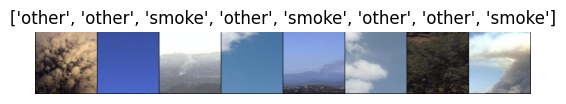

Prediction:


IndexError: ignored

In [ ]:
visualize_model(main_model)

In [ ]:

model = train_model(main_model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=8)
torch.save(model.state_dict(), '2features/UCSD.pt')

Epoch 0/8
----------
Training batch 1000/1004.0
Validation batch 0/531

<ipython-input-25-e91e35471cd3>:71: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)


Validation batch 500/531
Epoch 0 result: 
Avg loss (train): 0.0628
Avg acc (train): 0.7666
Avg loss (val): 0.0263
Avg acc (val): 0.9274
----------

Epoch 1/8
----------
Training batch 1000/1004.0
Validation batch 500/531
Epoch 1 result: 
Avg loss (train): 0.0395
Avg acc (train): 0.8632
Avg loss (val): 0.0216
Avg acc (val): 0.9335
----------

Epoch 2/8
----------
Training batch 1000/1004.0
Validation batch 500/531
Epoch 2 result: 
Avg loss (train): 0.0338
Avg acc (train): 0.8861
Avg loss (val): 0.0200
Avg acc (val): 0.9354
----------

Epoch 3/8
----------
Training batch 1000/1004.0
Validation batch 500/531
Epoch 3 result: 
Avg loss (train): 0.0323
Avg acc (train): 0.8949
Avg loss (val): 0.0153
Avg acc (val): 0.9524
----------

Epoch 4/8
----------
Training batch 1000/1004.0
Validation batch 500/531
Epoch 4 result: 
Avg loss (train): 0.0303
Avg acc (train): 0.8953
Avg loss (val): 0.0189
Avg acc (val): 0.9418
----------

Epoch 5/8
----------
Training batch 1000/1004.0
Validation batch 500

In [ ]:
eval_model(main_model, criterion)

Evaluating model
----------
Test batch 0/256

<ipython-input-27-ea058cfcd8dd>:22: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)


Test batch 200/256
Evaluation completed in 0m 10s
Avg loss (test): 0.0311
Avg acc (test): 0.9147
----------


<ipython-input-26-8ec5502ca051>:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)


Ground truth:


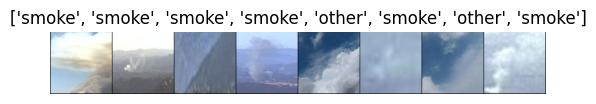

Prediction:


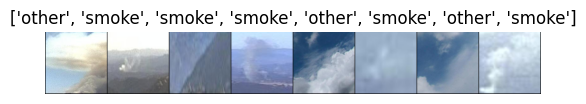

In [ ]:
visualize_model(main_model)

In [ ]:
from PIL import Image
import pandas as pd

from torchvision import transforms
transform = transforms.Compose([            #[1]
 transforms.Resize(256),                    #[2]
 transforms.CenterCrop(224),                #[3]
 transforms.ToTensor(),                     #[4]
 transforms.Normalize(                      #[5]
 mean=[0.485, 0.456, 0.406],                #[6]
 std=[0.229, 0.224, 0.225]                  #[7]
 )])


In [ ]:
list = []
for filename in os.listdir("/content/sage-training/clear_sky/"):

    if "._" not in filename and ".DS_Store" not in filename:

        main_model.load_state_dict(torch.load('/content/drive/MyDrive/UCSDmodel(3features).pt'))


        class_names = ['cloud', 'other', 'smoke']

        # num_features = vgg16.classifier[6].in_features
        # features = list(vgg16.classifier.children())[:-1] # Remove last layer
        # features.extend([nn.Linear(num_features, len(class_names))]) # Add our layer with 4 outputs
        # vgg16.classifier = nn.Sequential(*features) # Replace the model classifier

        image = Image.open("/content/sage-training/clear_sky/" + filename)
        image = image.crop((874, 874, 1174, 1174))
        img_t = transform(image)
        batch_t = torch.unsqueeze(img_t, 0)

        main_model.eval()
        out = main_model(batch_t.cuda())

        _, index = torch.max(out, 1)

        percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100

        d = {"Class": class_names[index[0]], "Percentage": percentage[index[0]].item()}
        list.append(d)

import pandas as pd
df3 = pd.DataFrame(list)

In [ ]:
df3

,Class,Percentage
0,other,99.979706
1,other,99.562439
2,other,99.985634
3,other,99.837036
4,other,92.950317
...,...,...
114,other,99.999306
115,cloud,70.879517
116,cloud,92.996094
117,other,99.998734


In [ ]:
list = []
for filename in os.listdir("/content/sage-training/clouds/"):

    if "._" not in filename and ".DS_Store" not in filename:

        main_model.load_state_dict(torch.load('/content/drive/MyDrive/UCSDmodel(3features).pt'))


        class_names = ['cloud', 'other', 'smoke']

        # num_features = vgg16.classifier[6].in_features
        # features = list(vgg16.classifier.children())[:-1] # Remove last layer
        # features.extend([nn.Linear(num_features, len(class_names))]) # Add our layer with 4 outputs
        # vgg16.classifier = nn.Sequential(*features) # Replace the model classifier

        image = Image.open("/content/sage-training/clouds/" + filename)
        image = image.crop((874, 874, 1174, 1174))
        img_t = transform(image)
        batch_t = torch.unsqueeze(img_t, 0)

        main_model.eval()
        out = main_model(batch_t.cuda())

        _, index = torch.max(out, 1)

        percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100

        d = {"Class": class_names[index[0]], "Percentage": percentage[index[0]].item()}
        list.append(d)

import pandas as pd
df2 = pd.DataFrame(list)

In [ ]:
len(df2[df2.Class == "smoke"]) / len(df2)

0.026923076923076925

In [ ]:
list = []
for filename in os.listdir("/content/sage-training/obstructed/"):

    if "._" not in filename and ".DS_Store" not in filename:

        main_model.load_state_dict(torch.load('/content/drive/MyDrive/UCSDmodel(3features).pt'))


        class_names = ['cloud', 'other', 'smoke']

        # num_features = vgg16.classifier[6].in_features
        # features = list(vgg16.classifier.children())[:-1] # Remove last layer
        # features.extend([nn.Linear(num_features, len(class_names))]) # Add our layer with 4 outputs
        # vgg16.classifier = nn.Sequential(*features) # Replace the model classifier

        image = Image.open("/content/sage-training/obstructed/" + filename)
        image = image.crop((874, 874, 1174, 1174))
        img_t = transform(image)
        batch_t = torch.unsqueeze(img_t, 0)

        main_model.eval()
        out = main_model(batch_t.cuda())

        _, index = torch.max(out, 1)

        percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100

        d = {"Class": class_names[index[0]], "Percentage": percentage[index[0]].item()}
        list.append(d)

import pandas as pd
df = pd.DataFrame(list)

In [ ]:
df

,Class,Percentage
0,cloud,72.307678
1,other,73.996155
2,cloud,95.883492
3,cloud,56.586380
4,smoke,64.264626
...,...,...
451,other,97.639023
452,other,58.667576
453,cloud,99.981339
454,cloud,44.982162


In [ ]:
len(df[df.Class == "smoke"]) / len(df)

0.09429824561403509

0
other  at confidence score:1.00
0
other  at confidence score:1.00
0
other  at confidence score:1.00
0
other  at confidence score:1.00
0
other  at confidence score:1.00
0
other  at confidence score:1.00
0
other  at confidence score:1.00
0
other  at confidence score:1.00
0
other  at confidence score:1.00
0
other  at confidence score:1.00
0
other  at confidence score:1.00
0
other  at confidence score:1.00
0
other  at confidence score:0.99
0
other  at confidence score:1.00
0
other  at confidence score:1.00
0
other  at confidence score:1.00
0
other  at confidence score:1.00
0
other  at confidence score:1.00
0
other  at confidence score:1.00
0
other  at confidence score:1.00
0
other  at confidence score:1.00
0
other  at confidence score:1.00
0
other  at confidence score:1.00
0
other  at confidence score:1.00
0
other  at confidence score:1.00
0
other  at confidence score:1.00
0
other  at confidence score:1.00
0
other  at confidence score:1.00
0
other  at confidence score:1.00
0
other  at co

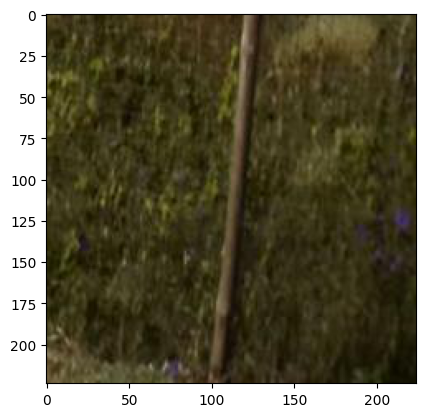

In [ ]:
dir = "/home/jszumny/Downloads/"


from PIL import Image, ImageChops
import io

# fullimage = Image.open("/home/jszumny/Arm Data/enatwrcamtarmacC1.a1.20221001.001123.jpg/enatwrcamtarmacC1.a1.20221001.153223.jpg")
# fullimage = fullimage.resize((2688, 2240))

main_model.to("cpu")

def transform_image(image_bytes):
    my_transforms = transforms.Compose([transforms.Resize(255),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize(
                                            [0.485, 0.456, 0.406],
                                            [0.229, 0.224, 0.225])])
    image = Image.open(io.BytesIO(image_bytes))
    return my_transforms(image).unsqueeze(0)


class_names = ["other", "smoke"]



def get_prediction(image_bytes):
    tensor = transform_image(image_bytes=image_bytes)
    output = main_model.forward(tensor)

    probs = torch.nn.functional.softmax(output, dim=1)
    conf, classes = torch.max(probs, 1)
    print(classes.item())
    return conf.item(), class_names[classes.item()]



data = []
dir = "/content/enatwrcamtarmacC1.a1.20221001.001123.jpg/"
imagetime = 0
for image in os.listdir(dir):
    if (int(image[30:36]) >= 144400) & (int(image[30:36]) <= 155000) & (int(image[32:34]) % 5 == 0):
    # if (((int(image[30:36]) >= 73000) & (int(image[30:36]) <= 142000)) |
    #     ((int(image[30:36]) >= 155600) & (int(image[30:36]) <= 193000))) & (int(image[32:34]) % 5 == 0) :
        imagetime = image[30:36]
        fullimage = Image.open(dir + image)
        fullimage = fullimage.resize((1344, 1344))
        fullimage = fullimage.crop((0, 448, 1344, 1344))


        for i in range(6):
            for k in range(4):
                main_model.load_state_dict(torch.load('/content/2features/UCSD.pt'))

                main_model.eval()

                tile = fullimage.crop((i*224, k*224, (i+1)*224, (k+1)*224))
                # tile = ImageChops.invert(tile)
                tile.save('/content/test/' + str(i) + "_" + str(k) + '.jpg')


                image_path= ("/content/test/" + str(i) + "_" + str(k) + '.jpg')
                image = plt.imread(image_path)
                plt.imshow(image)

                with open(image_path, 'rb') as f:
                    image_bytes = f.read()

                    conf,y_pre=get_prediction(image_bytes=image_bytes)
                    print(y_pre, ' at confidence score:{0:.2f}'.format(conf))

                d = {"imagetime": imagetime,"xtile": str(i), "ytile": str(k),"class": y_pre, "percentage": '{0:.2f}'.format(conf)}
                data.append(d)

In [ ]:
import pandas as pd
df = pd.DataFrame(data)
df.to_csv("/content/smoke-2features-UCSD.csv")

In [ ]:
df[df['class']=='smoke']

,imagetime,xtile,ytile,class,percentage


In [ ]:
nb_classes = 3

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['test']):
        inputs = inputs.to('cuda')
        classes = classes.to('cuda')
        outputs = main_model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


tensor([[463.,   6.,   9.],
        [ 18., 724.,  50.],
        [ 55.,  46., 472.]])
